In [2]:
import random 
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.cluster import KMeans
import pprint

In [115]:
class wsn:
    def __init__(self,**kwargs):
        
        self.actions = [0,1,2] # 0=Sleep,1=Transmit,2=Dead
        self.n_actions = len(self.actions)
        self.reward = 10
        self.noreward = 0
        self.NodesLists = self.cn(20)
        self.p_node=[]
        self.b_node=[]

    def step(self,action):
        
        if action == 0:

                for i in range(1,len(self.NodesLists)):
                    
                    if(self.NodesLists[i]['isDead'] == False and self.NodesLists[i]['wantToSendData'] == False):
                            self.NodesLists[i]['energy'] -= self.idleEnergy(10000)
                            done = False
                            return(0,0,done)
                    
                    elif(self.NodesLists[i]['isDead'] == True):
                        done = True
                        return(2,0,done)
                    
                    else :
                        done = False 
                        return(1,10,done)
                    
                return(0,0,done)
        
        elif action == 1:
            
            if all(self.NodesLists[i]['isDead'] == True for i in range(1,len(self.NodesLists))):
                done = True
                return(2,10,done)
            
            for i in range(len(self.b_node)):
                    c = random.choice(self.b_node)
                    self.NodesLists[self.b_node[i]['id']]['energy'] -= self.transmissionEnergy(10000,self.euclid_dist(248.2784962697276,-227.72180877478348,self.NodesLists[c['id']]['location']['x'],self.NodesLists[c['id']]['location']['y']))
                    self.NodesLists[c['id']]['energy'] -= self.receivingEnergy(10000)
                    done = False
                    return(0, 10, done)      
        
        else :
            
            if all(self.NodesLists[i]['isDead'] == True for i in range(1,len(self.NodesLists))):
                done = True
                return(2,0,done)
            
            for i in range(1,len(self.NodesLists)):
                if(self.NodesLists[i]['energy'] <= self.NodesLists[i]['threshold']):
                    self.NodesLists[i]['isDead'] = True
                    done = True
                    return(0,0,done)
            
                else:
                    done = False
                    return(1,10,done)
        
    def start(self):
        
        factor=5
        X=[]
        Y=[]

        random.seed(10)

        number_of_points = 20
        for i in range(number_of_points):
            X.append(-50*factor+100*factor*random.random())
            Y.append(-50*factor+100*factor*random.random())
        
        base_stnX = 150
        base_stnY = 300
        
       #K Means

        df=[]
        for i in range(len(self.NodesLists)-1):
            df.append([X[i],Y[i]])

        kmeans = KMeans(n_clusters=2)
        kmeans.fit(df)

        for i in range(1,len(self.NodesLists)):
            if kmeans.labels_[i-1] == 1:
                self.b_node.append(self.NodesLists[i])
            else:
                self.p_node.append(self.NodesLists[i])
        
        maxRound = 50

        for i in range(maxRound):
            self.b_node = self.calculateClusterHead(self.b_node,i)
            for j in range(1,len(self.b_node)):
                if(self.b_node[j]['isClusterHead']==True):
                    (x,y)=(self.b_node[j]['location']['x'],self.b_node[j]['location']['y'])

        plt.scatter(X, Y,c=kmeans.labels_)
        plt.scatter(base_stnX,base_stnY,c='red')
        plt.scatter(x,y,c='blue')
        plt.show()    
        

    def cn(self,x):
        
        factor=5
        X=[]
        Y=[]

        random.seed(10)

        number_of_points = x
        
        for i in range(number_of_points):
                X.append(-50*factor+100*factor*random.random())
                Y.append(-50*factor+100*factor*random.random())
        
        NodesList=[]
        NodesList.append([])
        

        for i in range(len(X)):
    
            Node = {'id':0,'energy': 0,'location':{'x':0,'y': 0,},'isClusterHead': False,'isDead':False,'threshold':0.1,'lastTimeCH':-1,'wantToSendData':False}
            Node['id'] = i+1
            Node['energy'] = 5   # Energy of Each node is 5 Joules
            Node['location']['x'] = X[i]
            Node['location']['y'] = Y[i]
            Node['isClusterHead']=False
    
            NodesList.append(Node)
        return(NodesList)
    
# Function to calculate energy by nodes to transmit a packet between two nodes 
    def transmissionEnergy(self,k,d):
        return 50*pow(10,-6)*k+10*pow(10,-9)*(d**2)*k 

# Function to calculate energy consummed by node while receiving any packet
    def receivingEnergy(self,k):
        return 50*pow(10,-6)*k 

# Function to calculate idle energy
    def idleEnergy(self,k):
        return 40*pow(10,-6)*k 
        
    def reset(self):
        return 0
    
    def render(self): 
        pass
   
    def print_value_all(self,q_table):
        
        for i in range(3):
            for j in range(3):
                print(q_table[i][j], end = " ")
            print()
            

    def calculateClusterHead(self,b_node,roundNum):
    
        P=0.08  
        x=(P*(roundNum%round(1/P)))
        if(roundNum%(1/P)==0):
            for i in range(1,len(b_node)):
                b_node[i]['lastTimeCH'] = -1
        T=(P/(1-x))

        flag = True
        cnt = 0
        
        for i in range(1,len(b_node)):
            if((b_node[i]['lastTimeCH']==-1 and b_node[i]['isDead']==False) or (b_node[i]['lastTimeCH']!=-1 and roundNum>=b_node[i]['lastTimeCH']+(1/P) and b_node[i]['energy']>=b_node[i]['threshold'] and b_node[i]['isDead']==False) ):
                random_num=random.random()
                cnt+=1
                if(random_num<=T):
                    flag = False
                    b_node[i]['isClusterHead']=True
                    b_node[i]['lastTimeCH']=roundNum
    
        while(flag==True and cnt!=0):
        
            for i in range(1,len(b_node)):
                if( (b_node[i]['lastTimeCH']==-1 and b_node[i]['isDead']==False ) or (b_node[i]['lastTimeCH']!=-1 and roundNum>=b_node[i]['lastTimeCH']+(1/P) and b_node[i]['energy']>=b_node[i]['threshold'] ) ):
                    random_num=random.random()
                    if(random_num<=T):
                        flag = False
                        b_node[i]['isClusterHead']=True
                        b_node[i]['lastTimeCH']=roundNum
        return (b_node)
    
    def euclid_dist(self,a1,a2,b1,b2):
        return (math.sqrt((a1-b1)**2+(a2-b2)**2))

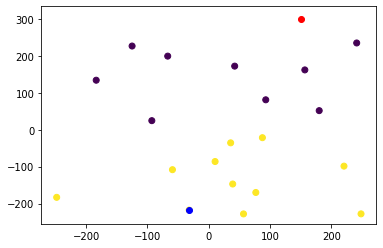

0
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 0.0 
2
0.0 0.0 0.5 
0.0 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 0.5 
0.022500000000000003 0.0 0.0 
0.0 0.0 0.0 
2
0.0 0.0 0.9760125000000001 
0.022500000000000003 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 0.9760125000000001 
0.06529556250000002 0.0 0.0 
0.0 0.0 0.0 
2
0.0 0.0 1.4301501753125 
0.06529556250000002 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 1.4301501753125 
0.1263875422640625 0.0 0.0 
0.0 0.0 0.0 
2
0.0 0.0 1.864330105948758 
0.1263875422640625 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 1.864330105948758 
0.2039630199185535 0.0 0.0 
0.0 0.0 0.0 
2
0.0 0.0 2.280291936547655 
0.2039630199185535 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 2.280291936547655 
0.2963780060672703 0.0 0.0 
0.0 0.0 0.0 
2
0.0 0.0 2.6796143499932996 
0.2963780060672703 0.0 0.0 
0.0 0.0 0.0 
0
0.0 0.0 2.6796143499932996 
0.4021417515136053 0.0 0.0 
0.0 0

In [116]:
class QLearningAgent:
    
    def __init__(self, actions):
        
        self.actions = actions
        self.learning_rate = 0.05
        self.discount_factor = 0.9
        self.epsilon = 0.1

        self.q_table = {0:[0.0,0.0,0.0],
                        1:[0.0,0.0,0.0],
                        2:[0.0,0.0,0.0]}
        
    
    def learn(self, state, action, reward, next_state):
        
        current_q = self.q_table[state][action]
        
        new_q = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (new_q - current_q)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            
            action = np.random.choice(self.actions)
        else:
          
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action

    def arg_max(self,state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

if __name__ == "__main__":
    
    env = wsn()
    env.start()
    agent = QLearningAgent(actions=list(range(env.n_actions)))

    for episode in range(25):
        state = env.reset()

        while True:
            env.render()

            action = agent.get_action(state)
            print(action)
            next_state, reward, done = env.step(action)


            agent.learn(state, action, reward, next_state)

            state = next_state
            
            env.print_value_all(agent.q_table)

            if done == True :
                break    
                
    print("*********x************")
    print("The Node List is")
    print("*********x************")
    
    pprint.pprint(env.NodesLists)

In [26]:
def euclid_dist(a1,a2,b1,b2):
    return (math.sqrt((a1-b1)**2+(a2-b2)**2))

In [27]:
def calculateClusterHead(NodesList,roundNum):
    
    P=0.08  
    x=(P*(roundNum%round(1/P)))
    if(roundNum%(1/P)==0):
        for i in range(1,len(NodesList)):
            NodesList[i]['lastTimeCH'] = -1
    T=(P/(1-x))
    print(T,x)
    
    count_=0
    flag = True
    cnt = 0

    for i in range(1,len(NodesList)):
        if( (NodesList[i]['lastTimeCH']==-1 and NodesList[i]['isDead']==False) or (NodesList[i]['lastTimeCH']!=-1 and roundNum>=NodesList[i]['lastTimeCH']+(1/P) and NodesList[i]['energy']>=NodesList[i]['threshold'] and NodesList[i]['isDead']==False) ):
            random_num=random.random()
            cnt+=1
            if(random_num<=T):
                flag = False
                count_+=1
                NodesList[i]['isClusterHead']=True
                NodesList[i]['lastTimeCH']=roundNum
    print("Total number of candidate for selection:",cnt)
    
    while(flag==True and cnt!=0):
        
        for i in range(1,len(NodesList)):
            if( (NodesList[i]['lastTimeCH']==-1 and NodesList[i]['isDead']==False) or (NodesList[i]['lastTimeCH']!=-1 and roundNum>=NodesList[i]['lastTimeCH']+(1/P) and NodesList[i]['energy']>=NodesList[i]['threshold']) ):
                random_num=random.random()
                if(random_num<=T):
                    flag = False
                    count_+=1
                    NodesList[i]['isClusterHead']=True
                    NodesList[i]['lastTimeCH']=roundNum
    NodesList[0]=count_
    return NodesList

In [28]:
factor=5
X=[]
Y=[]

random.seed(10)

number_of_points = 20
for i in range(number_of_points):
    X.append(-50*factor+100*factor*random.random())
    Y.append(-50*factor+100*factor*random.random())
    
base_stnX = 150
base_stnY = 300

In [29]:
NodesList=[]
NodesList.append([])

for i in range(len(X)):
    
    Node = {'id':0,'energy': 0,'location':{'x':0,'y': 0,},'isClusterHead': False,'isDead':False,'threshold':0.1,'lastTimeCH':-1,'wantToSendData':False}
    Node['id'] = i+1
    Node['energy'] = 5000    # Energy of Each node is 5 miliJoules
    Node['location']['x'] = X[i]
    Node['location']['y'] = Y[i]
    Node['isClusterHead']=False
    
    NodesList.append(Node)

In [30]:
#K Means

df=[]
for i in range(len(NodesList)-1):
    df.append([X[i],Y[i]])

kmeans = KMeans(n_clusters=2)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

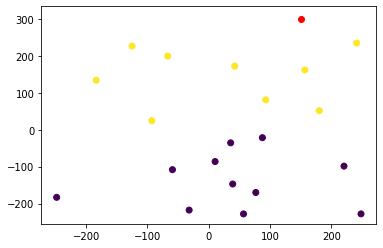

In [31]:
plt.scatter(X, Y,c=kmeans.labels_)
plt.scatter(base_stnX,base_stnY,c='red')

In [32]:
p_node = []
b_node = []

for i in range(1,len(NodesList)):
    if kmeans.labels_[i-1] == 1:
        b_node.append(NodesList[i])
    else:
        p_node.append(NodesList[i])
        
        
pprint.pprint(p_node)
pprint.pprint(b_node)

[{'energy': 5000,
  'id': 1,
  'isClusterHead': False,
  'isDead': False,
  'lastTimeCH': -1,
  'location': {'x': 35.70129734495674, 'y': -35.555472662442696},
  'threshold': 0.1,
  'wantToSendData': False},
 {'energy': 5000,
  'id': 2,
  'isClusterHead': False,
  'isDead': False,
  'lastTimeCH': -1,
  'location': {'x': 39.045650567235214, 'y': -146.95088393024912},
  'threshold': 0.1,
  'wantToSendData': False},
 {'energy': 5000,
  'id': 4,
  'isClusterHead': False,
  'isDead': False,
  'lastTimeCH': -1,
  'location': {'x': 76.73626695058789, 'y': -169.88522174059017},
  'threshold': 0.1,
  'wantToSendData': False},
 {'energy': 5000,
  'id': 5,
  'isClusterHead': False,
  'isDead': False,
  'lastTimeCH': -1,
  'location': {'x': 10.334679819962275, 'y': -86.11359418895341},
  'threshold': 0.1,
  'wantToSendData': False},
 {'energy': 5000,
  'id': 7,
  'isClusterHead': False,
  'isDead': False,
  'lastTimeCH': -1,
  'location': {'x': 248.2784962697276, 'y': -227.72180877478348},
  'thre

0.08 0.0
Total number of candidate for selection: 20
0.08695652173913043 0.08
Total number of candidate for selection: 19
0.09523809523809525 0.16
Total number of candidate for selection: 17
0.10526315789473684 0.24
Total number of candidate for selection: 16
0.11764705882352942 0.32
Total number of candidate for selection: 12
0.13333333333333333 0.4
Total number of candidate for selection: 11
0.15384615384615385 0.48
Total number of candidate for selection: 10
0.18181818181818185 0.56
Total number of candidate for selection: 9
0.22222222222222224 0.64
Total number of candidate for selection: 6
0.2857142857142857 0.72
Total number of candidate for selection: 5
0.4000000000000001 0.8
Total number of candidate for selection: 4
0.6666666666666667 0.88
Total number of candidate for selection: 0
0.08 0.0
Total number of candidate for selection: 0
0.08695652173913043 0.08
Total number of candidate for selection: 1
0.09523809523809525 0.16
Total number of candidate for selection: 2
0.10526315

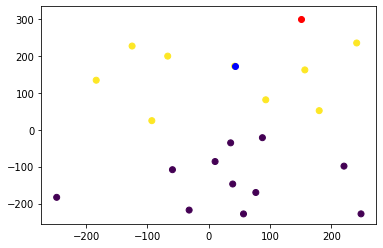

In [33]:
numberOfDeadNodesAxis=[]

maxRound = 50

for i in range(maxRound):
    NodesList = calculateClusterHead(NodesList,i)
    for j in range(1,len(NodesList)):
        if(NodesList[j]['isClusterHead']==True):
            (x,y)=(NodesList[j]['location']['x'],NodesList[j]['location']['y'])

plt.scatter(X, Y,c=kmeans.labels_)
plt.scatter(base_stnX,base_stnY,c='red')
plt.scatter(x,y,c='blue')
plt.show()         

In [34]:
d=[]
for j in range(1,len(NodesList)):
    d.append(euclid_dist(NodesList[j]['location']['x'],NodesList[j]['location']['y'],base_stnX,base_stnY))

In [91]:
def transmissionEnergy(k,d):
        return 50*pow(10,-6)*k+10*pow(10,-9)*(d**2)*k 

# Function to calculate energy consummed by node while receiving any packet
def receivingEnergy(k):
        return 50*pow(10,-6)*k 

# Function to calculate idle energy
def idleEnergy(k):
        return 40*pow(10,-6)*k 

for i in range(len(b_node)):
                    c = random.choice(b_node)
                    NodesList[b_node[i]['id']]['energy'] -= transmissionEnergy(10000,euclid_dist(35.70129734495674,-35.555472662442696,NodesList[c['id']]['location']['x'],NodesList[c['id']]['location']['y']))
                    NodesList[c['id']]['energy'] -= receivingEnergy(10000)
                    done = False                

In [93]:
print(NodesList)

[1, {'id': 1, 'energy': 4938.032612765951, 'location': {'x': 35.70129734495674, 'y': -35.555472662442696}, 'isClusterHead': True, 'isDead': False, 'threshold': 0.1, 'lastTimeCH': 43, 'wantToSendData': True}, {'id': 2, 'energy': 5000, 'location': {'x': 39.045650567235214, 'y': -146.95088393024912}, 'isClusterHead': True, 'isDead': False, 'threshold': 0.1, 'lastTimeCH': 44, 'wantToSendData': True}, {'id': 3, 'energy': 4995.987717521459, 'location': {'x': 156.66062567866004, 'y': 161.79443626672276}, 'isClusterHead': True, 'isDead': False, 'threshold': 0.1, 'lastTimeCH': 42, 'wantToSendData': False}, {'id': 4, 'energy': 5000, 'location': {'x': 76.73626695058789, 'y': -169.88522174059017}, 'isClusterHead': True, 'isDead': False, 'threshold': 0.1, 'lastTimeCH': 47, 'wantToSendData': True}, {'id': 5, 'energy': 5000, 'location': {'x': 10.334679819962275, 'y': -86.11359418895341}, 'isClusterHead': True, 'isDead': False, 'threshold': 0.1, 'lastTimeCH': 41, 'wantToSendData': True}, {'id': 6, 'en